# Mandelon

MADELON is an artificial dataset containing data points grouped in 32 clusters placed on the vertices of a five dimensional hypercube and randomly labeled +1 or -1. The five dimensions constitute 5 informative features. 15 linear combinations of those features were added to form a set of 20 (redundant) informative features. Based on those 20 features one must separate the examples into the 2 classes (corresponding to the +-1 labels). We added a number of distractor feature called 'probes' having no predictive power. The order of the features and patterns were randomized.


Sources:
- https://github.com/dstrodtman/madelon

## Importamos librerías

In [1]:
import math
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, RobustScaler
from sklearn.decomposition import PCA
from scipy.stats import boxcox
from itertools import combinations
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from deap import base  # Estructura que permite agrupar todos los componentes de nuestro algoritmo en una misma bolsa
from deap import creator  # Permite crear los componentes de nuestro algoritmo
from deap import tools  # Contiene funciones precargadas
from joblib import Parallel, delayed
from scipy.io import arff
scaler = StandardScaler()

In [2]:
tra, trameta = arff.loadarff('/home/sebacastillo/ealab/data/madelon.trn.arff')
tst, tstmeta = arff.loadarff('/home/sebacastillo/ealab/data/madelon.tst.arff')
train = pl.DataFrame(tra)
test =  pl.DataFrame(tst)


In [3]:
train = (
    train.with_columns(
        pl.col('class').cast(pl.datatypes.Utf8)
    )   
)

test = (
    test.with_columns(
        pl.col('class').cast(pl.datatypes.Utf8)
    )   
)


In [4]:
train.groupby('class').agg(pl.count())

class,count
str,u32
"""-1""",1000
"""1""",1000


In [5]:
print(train.shape), print(test.shape)

(2000, 501)
(600, 501)


(None, None)

In [6]:
TRAIN = train
TEST = test

# Normalizamos los datos

In [7]:

TRAIN = TRAIN.to_numpy()
TEST = TEST.to_numpy()

X_TRAIN = TRAIN[:,:-1]
y_train = TRAIN[:,-1]
y_train = np.where(np.array(y_train) == '1', 1, 0).astype('int64')
X_TEST = TEST[:,:-1]
y_test = TEST[:,-1]
y_test = np.where(np.array(y_test) == '1', 1, 0).astype('int64')
scaler.fit(X_TRAIN)
X_train = scaler.transform(X_TRAIN)
X_test = scaler.transform(X_TEST)


# Bayesian Optimization

In [12]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC

from bayes_opt import BayesianOptimization
from bayes_opt.util import Colours

# 0 

In [13]:
def svc_cv(C, gamma, data, targets):
    """SVC cross validation.
    This function will instantiate a SVC classifier with parameters C and
    gamma. Combined with data and targets this will in turn be used to perform
    cross validation. The result of cross validation is returned.
    Our goal is to find combinations of C and gamma that maximizes the roc_auc
    metric.
    """
    estimator = SVC(C=C, gamma=gamma, random_state=2)
    cval = cross_val_score(estimator, data, targets, scoring='roc_auc', cv=4)
    return cval.mean()

def optimize_svc(data, targets):
    """Apply Bayesian Optimization to SVC parameters."""
    def svc_crossval(expC, expGamma):
        """Wrapper of SVC cross validation.

        Notice how we transform between regular and log scale. While this
        is not technically necessary, it greatly improves the performance
        of the optimizer.
        """
        C = 10 ** expC
        gamma = 10 ** expGamma
        return svc_cv(C=C, gamma=gamma, data=data, targets=targets)

    optimizer = BayesianOptimization(
        f=svc_crossval,
        pbounds={"expC": (-3, 2), "expGamma": (-4, -1)},
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=100)

    print("Final result:", optimizer.max)


def rfc_cv(n_estimators, min_samples_split, max_features, data, targets):
    """Random Forest cross validation.
    This function will instantiate a random forest classifier with parameters
    n_estimators, min_samples_split, and max_features. Combined with data and
    targets this will in turn be used to perform cross validation. The result
    of cross validation is returned.
    Our goal is to find combinations of n_estimators, min_samples_split, and
    max_features that minimizes the log loss.
    """
    estimator = RFC(
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        max_features=max_features,
        random_state=2
    )
    cval = cross_val_score(estimator, data, targets,
                           scoring='neg_log_loss', cv=4)
    return cval.mean()

def optimize_rfc(data, targets):
    """Apply Bayesian Optimization to Random Forest parameters."""
    def rfc_crossval(n_estimators, min_samples_split, max_features):
        """Wrapper of RandomForest cross validation.

        Notice how we ensure n_estimators and min_samples_split are casted
        to integer before we pass them along. Moreover, to avoid max_features
        taking values outside the (0, 1) range, we also ensure it is capped
        accordingly.
        """
        return rfc_cv(
            n_estimators=int(n_estimators),
            min_samples_split=int(min_samples_split),
            max_features=max(min(max_features, 0.999), 1e-3),
            data=data,
            targets=targets,
        )

    optimizer = BayesianOptimization(
        f=rfc_crossval,
        pbounds={
            "n_estimators": (10, 250),
            "min_samples_split": (2, 25),
            "max_features": (0.1, 0.999),
        },
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=10)

    print("Final result:", optimizer.max)


In [ ]:
print(Colours.yellow("--- Optimizing SVM ---"))
optimize_svc(X_train, y_train)

In [ ]:
print(Colours.green("--- Optimizing Random Forest ---"))
optimize_rfc(data, targets)

# 1

In [8]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization

In [9]:
def objective(n_estimators, max_depth, min_samples_split, max_features):
    model = RandomForestRegressor(n_estimators=int(n_estimators),
                                  max_depth=int(max_depth),
                                  min_samples_split=int(min_samples_split),
                                  max_features=min(max_features, 0.999),  # Fraction, must be <= 1.0
                                  random_state=42)

    return -1.0 * cross_val_score(model, X_train, y_train, cv=3, scoring="neg_mean_squared_error").mean()

In [10]:
# Bounds for hyperparameters
param_bounds = {
    'n_estimators': (10, 250),
    'max_depth': (1, 50),
    'min_samples_split': (2, 25),
    'max_features': (0.1, 0.999),
}

In [ ]:
optimizer = BayesianOptimization(f=objective, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=15)

In [ ]:
best_params = optimizer.max['params']

In [ ]:
best_params_formatted = {
    'n_estimators': int(best_params['n_estimators']),
    'max_depth': int(best_params['max_depth']),
    'min_samples_split': int(best_params['min_samples_split']),
    'max_features': best_params['max_features']
}


In [ ]:
optimized_rf = RandomForestRegressor(**best_params_formatted, random_state=42)

In [ ]:
optimized_rf.fit(X_train, y_train)

# 2

In [8]:
from sklearn.metrics import roc_auc_score
from bayes_opt import BayesianOptimization, UtilityFunction

In [20]:
# Create the optimizer. The black box function to optimize is not
# specified here, as we will call that function directly later on.
optimizer = BayesianOptimization(f = None, 
                                 pbounds = {"C": [0.01, 100], 
                                            "degree": [1, 10],
                                            "gamma": [0.001, 1]
                                            }, 
                                 verbose = 2, random_state = 1234)
# Specify the acquisition function (bayes_opt uses the term
# utility function) to be the upper confidence bounds "ucb".
# We set kappa = 1.96 to balance exploration vs exploitation.
# xi = 0.01 is another hyper parameter which is required in the
# arguments, but is not used by "ucb". Other acquisition functions
# such as the expected improvement "ei" will be affected by xi.
utility = UtilityFunction(kind = "ucb", kappa = 1.96, xi = 0.01)
# We want to optimize both C and degree simultaneously.
def black_box_function(C, degree, gamma):
    model = SVC(C = C, degree = degree, gamma=gamma)
    model.fit(X_train, y_train)
    y_score = model.decision_function(X_test)
    f = roc_auc_score(y_test, y_score)
    return f


In [23]:
# Optimization for loop.
for i in range(100):
    # Get optimizer to suggest new parameter values to try using the
    # specified acquisition function.
    next_point = optimizer.suggest(utility)
    # Force degree from float to int.
    next_point["degree"] = int(next_point["degree"])
    # Evaluate the output of the black_box_function using 
    # the new parameter values.
    target = black_box_function(**next_point)
    try:
        # Update the optimizer with the evaluation results. 
        # This should be in try-except to catch any errors!
        optimizer.register(params = next_point, target = target)
    except:
        pass


Best result: {'C': 12.624645437958755, 'degree': 4.0, 'gamma': 0.012304224620301972}; f(x) = 0.630.


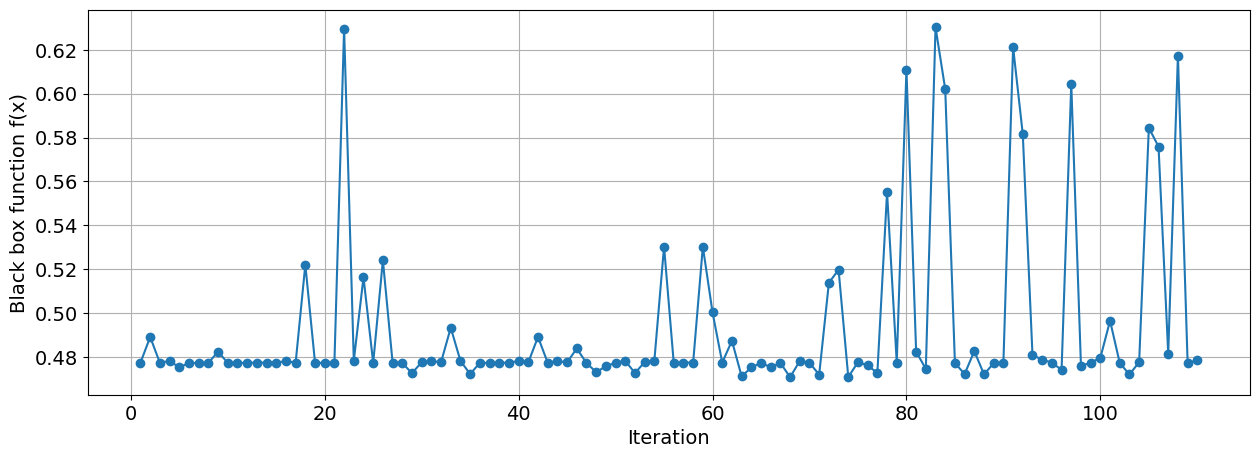

In [24]:
print("Best result: {}; f(x) = {:.3f}.".format(optimizer.max["params"], optimizer.max["target"]))
plt.figure(figsize = (15, 5))
plt.plot(range(1, 1 + len(optimizer.space.target)), optimizer.space.target, "-o")
plt.grid(True)
plt.xlabel("Iteration", fontsize = 14)
plt.ylabel("Black box function f(x)", fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()